In [3]:
# 用子类API来实现wide&deep模型，进行房价预测

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

In [4]:
# 获取房价数据集
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)    # X
print(housing.target.shape)  # Y

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
# 拆分训练集、验证集和测试集
from sklearn.model_selection import train_test_split
# 默认按照3:1进行拆分，可设置test_size参数进行改变，其默认为0.25
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7, test_size = 0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [6]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler = scaler.transform(x_test)

In [7]:
# 子类API实现
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        '''定义模型的层次'''
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer =  keras.layers.Dense(1)
        
    def call(self, input):
        '''完成模型的正向计算'''
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

model = WideDeepModel()
model.build(input_shape = (None, 8))
# 打印一下模型的信息
model.summary()
# 均方差 随机梯度下降
model.compile(loss='mean_squared_error', optimizer='adam')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  270       
_________________________________________________________________
dense_1 (Dense)              multiple                  930       
_________________________________________________________________
dense_2 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(x_train_scaler, y_train, validation_data=(x_valid_scaler, y_valid),
                   epochs = 100, callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 151us/sample - loss: 1.1632 - val_loss: 0.6642
Epoch 2/100
11610/11610 [==============================] - 1s 112us/sample - loss: 0.5040 - val_loss: 0.4642
Epoch 3/100
11610/11610 [==============================] - 1s 103us/sample - loss: 0.4154 - val_loss: 0.4099
Epoch 4/100
11610/11610 [==============================] - 1s 97us/sample - loss: 0.3860 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 1s 93us/sample - loss: 0.3695 - val_loss: 0.3861
Epoch 6/100
11610/11610 [==============================] - 1s 93us/sample - loss: 0.3731 - val_loss: 0.3764
Epoch 7/100
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3521 - val_loss: 0.3510
Epoch 8/100
11610/11610 [==============================] - 1s 100us/sample - loss: 0.3388 - val_loss: 0.3459
Epoch 9/100
11610/11610 [==============================] - 1s 92us/sample - loss: 0

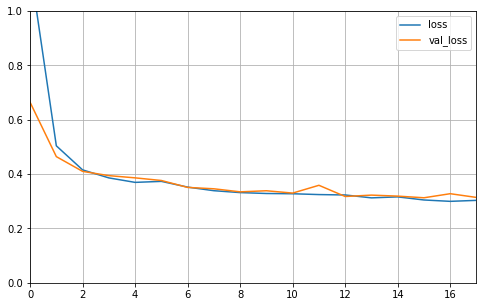

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [10]:
# 用测试集进行模型的评估    .返回损失值&模型的度量值
model.evaluate(x_test_scaler, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3226917276086733